✅ Step1: 时间列为 date，数据范围：2016-07-01 00:00:00 ~ 2018-06-26 19:00:00
当前形状: (17420, 8)
✅ Step2: 已重建完整时间轴，共 17420 个时间步（每小时）
检测并修复以下数值列: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
✅ Step3: 异常值已置为 NaN
✅ Step4: 目标列已平滑处理


/tmp/ipykernel_2076/1712784848.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df[time_col].min(),


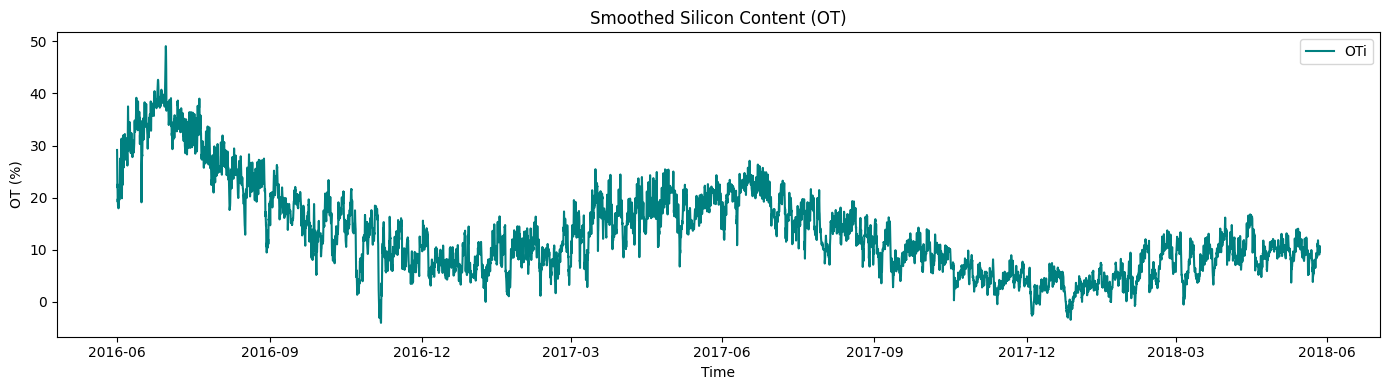

✅ Step6: 数据处理完成，已导出至 new_ETTh1.csv
最终形状: (17420, 8)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# Step 0. 读取原始数据
# ==============================
# ⚠️ 修改为你自己的文件名
df = pd.read_csv("ETTh1.csv", encoding="utf-8-sig")

# ------------------------------
# Step 1. 统一时间列
# ------------------------------
# 找出时间列名（假设含“时间”或“date”等关键词）
time_col = [c for c in df.columns if "时间" in c or "date" in c.lower()][0]
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")

# 删除时间为空的行
df = df.dropna(subset=[time_col]).sort_values(time_col)
df = df.reset_index(drop=True)

print(f"✅ Step1: 时间列为 {time_col}，数据范围：{df[time_col].min()} ~ {df[time_col].max()}")
print(f"当前形状: {df.shape}")

# ------------------------------
# Step 2. 构造完整时间序列（保证连续时间步）
# ------------------------------
# 假设数据为每小时一个时间步
full_range = pd.date_range(start=df[time_col].min(),
                           end=df[time_col].max(),
                           freq="H")

# 设置索引为时间，并重建完整时间轴
df = df.set_index(time_col).reindex(full_range)
df.index.name = time_col

print(f"✅ Step2: 已重建完整时间轴，共 {len(df)} 个时间步（每小时）")

# ------------------------------
# Step 3. 异常值检测与清洗（±3σ原则）
# ------------------------------
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
print(f"检测并修复以下数值列: {numeric_cols}")

for col in numeric_cols:
    mean, std = df[col].mean(), df[col].std()
    # 将超过 ±3σ 的异常值置为 NaN
    df[col] = df[col].mask((df[col] < mean - 3*std) | (df[col] > mean + 3*std))

print("✅ Step3: 异常值已置为 NaN")

# ------------------------------
# Step 4. 插值 & 平滑（保持趋势）
# ------------------------------
# 使用三次插值填充数值缺失（含前一步异常置NaN的）
df = df.interpolate(method="cubic", limit_direction="both")

# 目标列滚动均值平滑（减少测量噪声）
target_col = "OT"
if target_col in df.columns:
    df[target_col] = df[target_col].rolling(window=3, center=True, min_periods=1).mean()
    print("✅ Step4: 目标列已平滑处理")

# ------------------------------
# Step 5. 检查平滑效果（可视化）
# ------------------------------
plt.figure(figsize=(14, 4))
plt.plot(df.index, df[target_col], color="teal", label="OTi")
plt.title("Smoothed Silicon Content (OT)")
plt.xlabel("Time"); plt.ylabel("OT (%)"); plt.legend()
plt.tight_layout(); plt.show()

# ------------------------------
# Step 6. 输出结果
# ------------------------------
df = df.reset_index()  # 还原时间为列
output_path = "new_ETTh1.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"✅ Step6: 数据处理完成，已导出至 {output_path}")
print(f"最终形状: {df.shape}")
